<h1>[MAIN QUEST2]케라스 창시자에게 배우는 딥러닝</h1>

문제1. 이미지 segmentation model을 만들고, 전체 코드와 테스트 결과를 주피터 노트북 파일로 자신의 깃헙에 제출합니다<br>
문제2. 이미지 분할 학습 결과를 텐서보드로 시각화합니다

In [1]:
import os
import math

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import cv2

from PIL import Image
# from skimage.io import imread
# from skimage.transform import resize
from glob import glob

import tensorflow as tf

from tensorflow import data
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

In [2]:
import datasets
from datasets import load_dataset

In [ ]:
!unzip -uq "archive.zip" -d "activation"

<h3>데이터 불러오기</h3>

In [3]:
image_path = os.getenv('HOME')+'/aiffel/activation/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset/images'

In [4]:
print(len(os.listdir(image_path)))

600


<h3>바이트 값 변경</h3>

In [5]:
from tensorflow.keras.utils import Sequence, load_img, img_to_array, plot_model, to_categorical
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Input, Concatenate, Dropout
from keras.models import Model
from skimage.transform import resize


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

In [6]:
import os
import io
from PIL import Image
import numpy as np

def byte_to_rgb(image_path):
    # 이미지를 불러와서 byte로 변환
    with open(image_path, "rb") as f:
        byte_data = f.read()

    # byte를 PIL 이미지로 변환
    buffer = io.BytesIO(byte_data)
    image = Image.open(buffer)

    # 이미지를 RGB 배열로 변환
    image_rgb = image.convert("RGB")
    array_rgb = np.array(image_rgb)
    return array_rgb

In [7]:
data_train_image = []
data_label_image = []

for j, name in enumerate(np.arange(141)):
    label = f"{image_path}/Screenshot ({name+309}).png___fuse.png"
    
    if not os.path.exists(label):
        continue
    else :
        data_label_image.append(byte_to_rgb(label))
        
for j, name in enumerate(np.arange(141)):
    image = f"{image_path}/Screenshot ({name+309}).png"
    
    if not os.path.exists(image):
        continue 
    else :
        data_train_image.append(byte_to_rgb(image))

<h4>이미지를 byte로 변환하는 이유 : 데이터를 효율적으로 다루고 처리하기 위해서</h4><br>
특히 딥러닝 모델에 이미지를 입력하기 전에 데이터를 적절한 형식으로 변환하여 모델이 이해할 수 있는 형태로 전처리 하는 작업이 필요합니다.

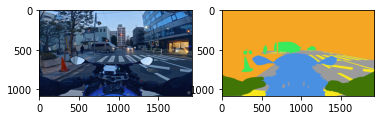

In [8]:
plt.subplot(1,2,1)
plt.imshow(data_train_image[50])
plt.subplot(1,2,2)
plt.imshow(data_label_image[50])
plt.show()

데이터가 image와 label로 잘 나누어진 것을 확인할 수 있다

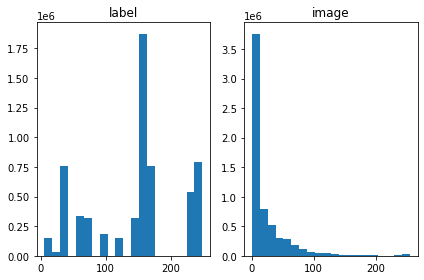

In [9]:
##한 이미지의 분포
plt.subplot(122)
plt.hist(data_train_image[0].flatten(), bins=20)
plt.title('image')

plt.subplot(121)
plt.hist(data_label_image[0].flatten(), bins=20)
plt.title('label')

plt.tight_layout()
plt.show()

픽셀값들의 분포를 확인할 수 있습니다.

In [10]:
target_shape = (192, 192)

In [11]:
target_shape = (192, 192)
import cv2
import numpy as np

def resize_image_opencv(image, target_shape=(256, 256)):
    return cv2.resize(image, target_shape[:2])

In [12]:
data_train_image_resize = [resize_image_opencv(img, target_shape) for img in data_train_image]
data_label_image_resize = [resize_image_opencv(img, target_shape) for img in data_label_image]

이미지를 resize하는 이유는 모델에 입력하기 전에 이미지의 크기를 조정하여 일관된 크기를 만들기 위함입니다. 딥러닝 모델에서 보통 이미지의 크기가 고정되어 있어야 합니다.

In [13]:
data_train_image_stack = np.stack(data_train_image_resize)
data_label_image_stack = np.stack(data_label_image_resize)

In [14]:
print(data_train_image_stack.shape)
print(data_label_image_stack.shape)

(104, 192, 192, 3)
(104, 192, 192, 3)


In [15]:
input_shape = data_train_image_stack[0].shape
input_shape

(192, 192, 3)

<h3>데이터 정규화</h3>

In [16]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    return x.astype(np.uint8)

In [17]:
def make_batch(data, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.shuffle(buffer_size=3000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [18]:
dataset_image = make_batch(data_train_image_stack)
dataset_label = make_batch(data_label_image_stack)

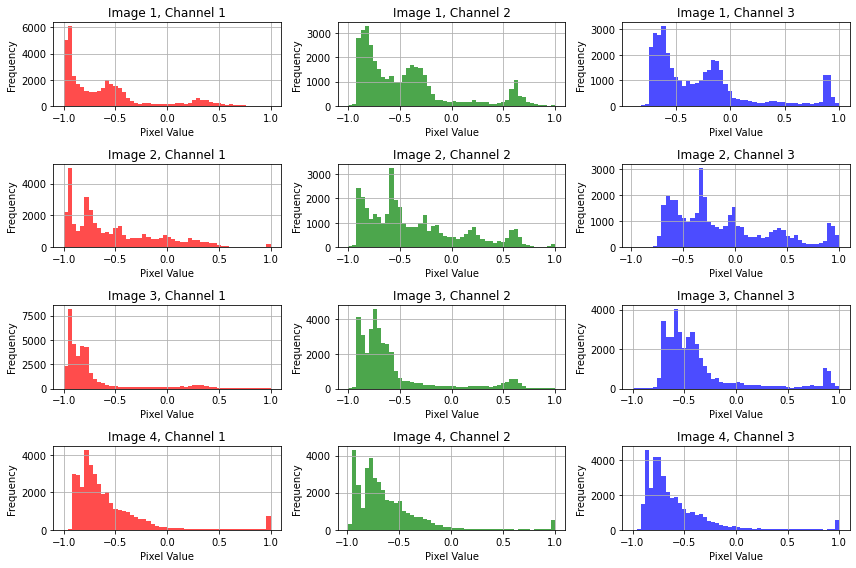

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋에서 이미지 가져오기
sample_images = next(iter(dataset_image))

# 이미지의 각 채널에 대한 픽셀 값 분포 확인 (몇 개의 이미지에 대해서만)
num_samples = 4  # 확인할 이미지 수
num_channels = sample_images.shape[-1]  # 채널 수 (RGB: 3)

plt.figure(figsize=(12, 8))
colors = ['red', 'green', 'blue']  # 색상 리스트
for i in range(num_samples):
    for j in range(num_channels):
        plt.subplot(num_samples, num_channels, i * num_channels + j + 1)
        channel_values = sample_images[i, :, :, j].numpy().ravel()  # 각 채널 값
        plt.hist(channel_values, bins=50, color=colors[j], alpha=0.7)  # 명시적인 색상 사용
        plt.title(f'Image {i + 1}, Channel {j + 1}')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.grid()

plt.tight_layout()
plt.show()

이미지의 각 채널에 대한 픽셀 값 분포를 확인해보았습니다

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


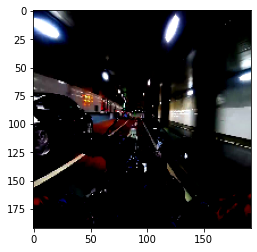

In [20]:
sample = dataset_image.take(1)
sample = list(sample.as_numpy_iterator())
plt.imshow(sample[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


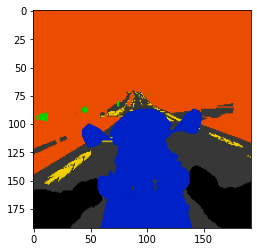

In [21]:
sample = dataset_label.take(1)
sample = list(sample.as_numpy_iterator())
plt.imshow(sample[0][0])

<h3>Augmentation</h3>

In [38]:
@tf.function()
def apply_augmentation(img):
    out = tf.image.random_flip_left_right(img)
    out = tf.image.random_flip_up_down(out)
    
    # 50% 확률로 이미지 회전
    if tf.random.uniform(()) < 0.5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = tf.image.rot90(out, k=degree)
    
    return out[..., :3]

In [42]:
image_augmented = dataset_image.map(apply_augmentation)
label_augmented = dataset_label.map(apply_augmentation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


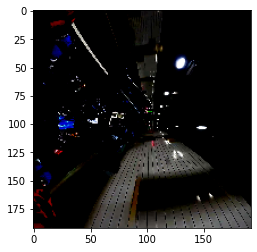

In [46]:
sample = image_augmented.take(1)
sample = list(sample.as_numpy_iterator())
plt.imshow(sample[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


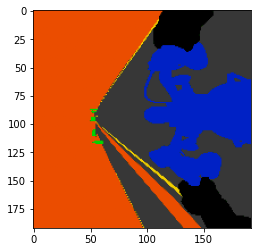

In [47]:
sample = label_augmented.take(1)
sample = list(sample.as_numpy_iterator())
plt.imshow(sample[0][0])

<h3>데이터 증강 효과</h3>

1. 데이터 부족 문제 해결 : 적은 데이터로도 모델을 학습시키는데 도움을 줍니다.
2. 모델의 일반화 향상 : 모델이 다양한 변형과 환경에서도 효과적으로 작동하도록 학습하게 돕습니다.
3. 과적합 방지  다양한 변형된 데이터를 사용하여 훈련하면 모델이 특정항 패턴에만 치우치지 않고 더 일반적인 특징을 학습하도록 도와줍니다.
4. 데이터 불균형 문제 완화
5. 강건성(Robustness)향상 : 노이즈, 회전, 크기 반환 등과 같은 다양한 상황에 대해 더 강건한 모델을 구축하는데 도움을 줍니다.

<h2>U-Net 네트워크 구축하기</h2>

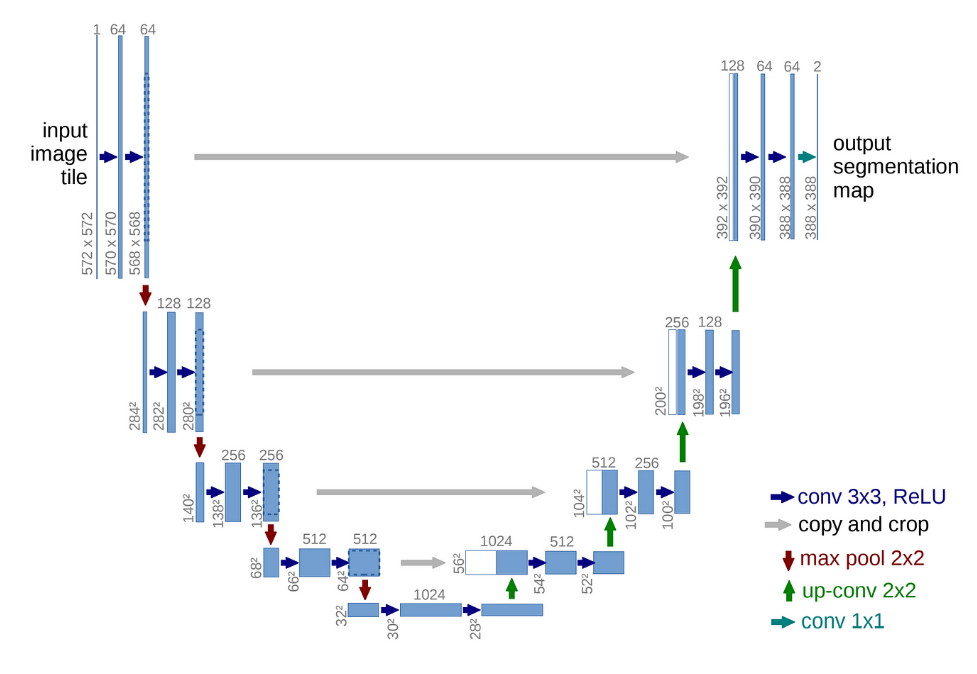

해당 그림을 살펴보게 되면 파란색 화살표가 반복되는 것을 확인할 수 있습니다. Conv 3x3 + Batch Normalization + Relu를 CBR2d라는 함수로 정의하고 이를 forward에서 반복해서 사용하도록 하겠습니다

In [48]:
from tensorflow import keras
from tensorflow.keras import layers, models

In [49]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [50]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [51]:
class UNetGenerator(models.Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [32,64,128,256]
        decode_filters = [256,128,64,32]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=input_shape):
        inputs = layers.Input(input_shape)
        return models.Model(inputs, self.call(inputs)).summary()

<h3>U-Net</h3>

FCN과 공통점은 원본 이미지 크기로 복원을 위한 Upsampling을 수행하고 그 과정에서 경계 정보를 살려내는 Skip Connection을 거친다는 점입니다<br>
반면에 차이점은 deconvolutopn으로 upsampling을 수행하는 과정 사이에 두번의 3x3 Conv과정이 껴있고, 학습 과정에서 over-tile과 데이터 증폭(data argumentation)을 사용한다는 점입니다.

In [52]:
UNetGenerator().get_summary(input_shape)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
encode_block_8 (EncodeBlock)    (None, 96, 96, 32)   1536        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_9 (EncodeBlock)    (None, 48, 48, 64)   33024       encode_block_8[0][0]             
__________________________________________________________________________________________________
encode_block_10 (EncodeBlock)   (None, 24, 24, 128)  131584      encode_block_9[0][0]             
____________________________________________________________________________________________

<h3>Discriminator</h3>

In [53]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [54]:
class Discriminator(models.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.blocks = [
            DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True),
            DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True),
            DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True),
            DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True),
            DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        ]
        self.sigmoid = layers.Activation("sigmoid")
            
    def call(self, x, y):
        out = self.block1([x, y])
        for block in self.blocks:
            out = block(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=input_shape, y_shape=input_shape):
        x, y = layers.Input(x_shape), layers.Input(y_shape) 
        return models.Model((x, y), self.call(x, y)).summary()

In [55]:
Discriminator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 192, 192, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block_10 (DiscBlock)       (None, 96, 96, 64)   6144        concatenate_8[0][0]        

<h2>학습</h2>

In [56]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [57]:
gene_opt = tf.keras.optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [58]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}
steps = len(dataset_image)

In [61]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss)
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [62]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [63]:
for epoch in range(1, EPOCHS+1):
    for i, (mask, image) in enumerate(zip(dataset_label, dataset_image)):
        g_loss, l1_loss, d_loss = train_step(mask, image)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)      
        
        # 진행률 표시
        elapsed = (i/steps) * 100
        if elapsed % 10 == 0:
            print('{:3}%'.format(int(elapsed)), end=' ')
            
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print()
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n")

  0% 
EPOCH[1] - STEP[10]                     
Generator_loss:0.9281                     
L1_loss:0.5009                     
Discriminator_loss:1.2061
 50% 
EPOCH[1] - STEP[20]                     
Generator_loss:1.2976                     
L1_loss:0.5195                     
Discriminator_loss:0.7887
  0% 
EPOCH[2] - STEP[10]                     
Generator_loss:1.8189                     
L1_loss:0.4052                     
Discriminator_loss:0.4223
 50% 
EPOCH[2] - STEP[20]                     
Generator_loss:1.9662                     
L1_loss:0.3833                     
Discriminator_loss:0.4928
  0% 
EPOCH[3] - STEP[10]                     
Generator_loss:3.3557                     
L1_loss:0.3654                     
Discriminator_loss:0.2932
 50% 
EPOCH[3] - STEP[20]                     
Generator_loss:2.5602                     
L1_loss:0.3695                     
Discriminator_loss:0.3365
  0% 
EPOCH[4] - STEP[10]                     
Generator_loss:3.6574                    

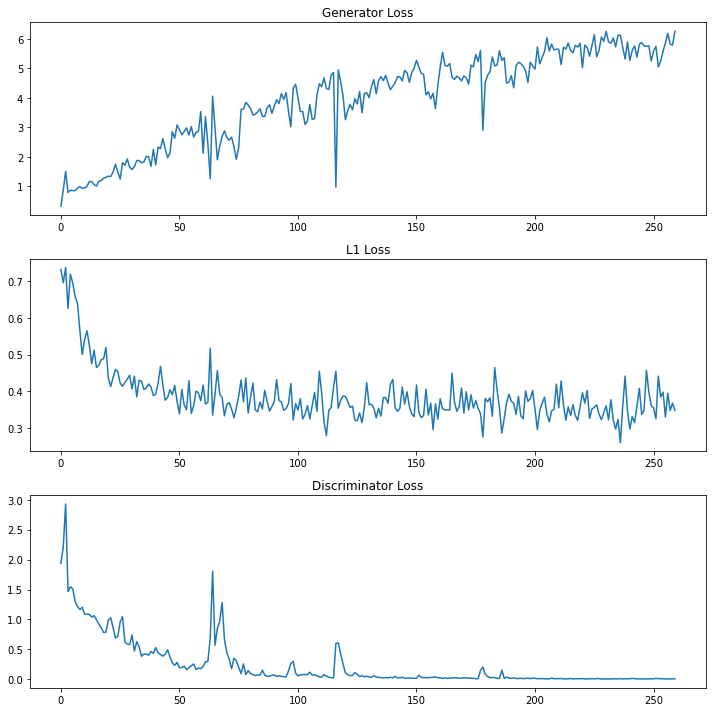

In [64]:
plt.figure(figsize=(10,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.tight_layout()
plt.show()

loss가 갑자기 증가하는 구간이 발생하여 다른 방법을 시도해보겠습니다

<h2>[업그레이드] U-Net 모델 수정</h2>

In [140]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512]
        decode_filters = [512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=True))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
           
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

여기서 각 블록의 필터수를 조정하여 모델의 용량을 좀더 늘려 보았습니다.<br>
이 경우 모델이 더 복잡한 패턴을 학습할 수 있습니다

<h3>Discriminator</h3>

In [141]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [142]:
class Discriminator(models.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.blocks = [
            DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True),
            DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True),
            DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True),
            DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True),
            DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        ]
        self.sigmoid = layers.Activation("sigmoid")
            
    def call(self, x, y):
        out = self.block1([x, y])
        for block in self.blocks:
            out = block(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=input_shape, y_shape=input_shape):
        x, y = layers.Input(x_shape), layers.Input(y_shape) 
        return models.Model((x, y), self.call(x, y)).summary()

<h2>학습</h2>

In [143]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [144]:
gene_opt = tf.keras.optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [145]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [146]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}
steps = len(dataset_image)

In [147]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss)
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [207]:
for epoch in range(1, EPOCHS+1):
    for i, (mask, image) in enumerate(zip(dataset_label, dataset_image)):
        g_loss, l1_loss, d_loss = train_step(mask, image)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)      
        
        # 진행률 표시
        elapsed = (i/steps) * 100
        if elapsed % 10 == 0:
            print('{:3}%'.format(int(elapsed)), end=' ')
            
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print()
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n")

TypeError: 'ellipsis' object is not subscriptable

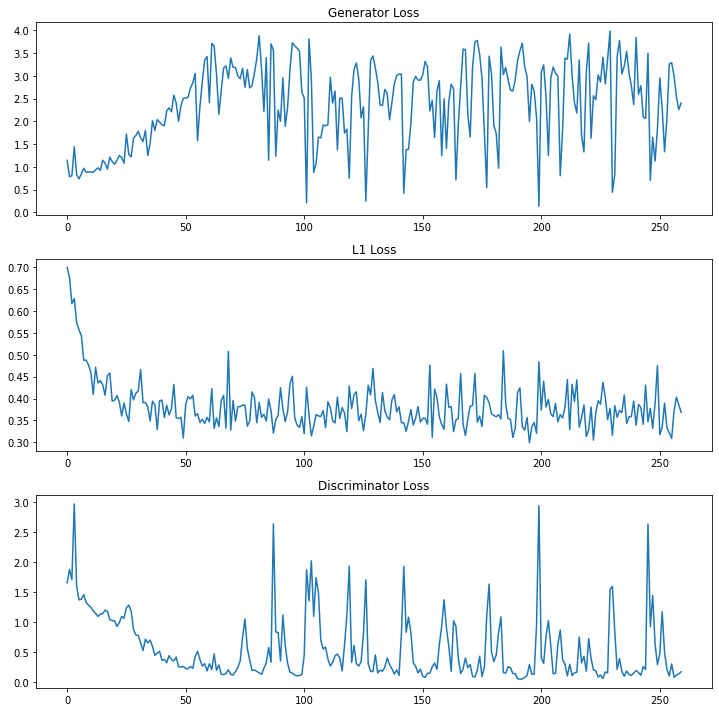

In [149]:
plt.figure(figsize=(10,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.tight_layout()
plt.show()

필터 수를 좀더 추가하고 dropout = True를 했을 때 loss가 확실히 줄어든 것을 볼 수 있습니다.

<h2>★Tensorboard★</h2>

In [172]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [183]:
# 예시: 이미지 데이터셋을 numpy 배열로 변환하여 가져오는 방법
train_inputs = []  # 이미지 데이터셋을 저장할 리스트
train_targets = []  # 타겟(라벨 등) 데이터셋을 저장할 리스트

for img in image_augmented.as_numpy_iterator():
    # 이미지를 train_inputs 리스트에 추가
    train_inputs.append(img)

for target in label_augmented.as_numpy_iterator():
    # 타겟 데이터를 train_targets 리스트에 추가
    train_targets.append(target)

# 리스트를 넘파이 배열로 변환
train_inputs = np.array(train_inputs)
train_targets = np.array(train_targets)

In [185]:
for inputs, targets in zip(image_augmented.as_numpy_iterator(), label_augmented.as_numpy_iterator()):
    loss = train_step(model, inputs, targets, optimizer)

In [206]:
for epoch in range(1, EPOCHS+1):
    for i, (mask, image) in enumerate(zip(dataset_label, dataset_image)):
        g_loss, l1_loss, d_loss = train_step(mask, image)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)      
        
        # 진행률 표시
        elapsed = (i/steps) * 100
        if elapsed % 10 == 0:
            print('{:3}%'.format(int(elapsed)), end=' ')
            
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print()
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n")

TypeError: 'ellipsis' object is not subscriptable

<h2>회고<h2>

In [ ]:

U-Net 필터수를 늘리고 dropout을 시도함으로써 성능이 향상되는 것을 확인할 수 있었습니다.


tensorboard가 잘 되지 않아 시간이 촉박하여 그냥 넘겨드립니다 ㅠㅠ

<h2>reference</h2>

Semantic Segmentation을 위한 U-Net 모델 : https://dacon.io/en/codeshare/4245<br>
 U-Net 논문, "U-Net: Convolutional Networks for Biomedical Image Segmentation(2015)" [Google Scholar]<br>
  FCN 논문, "Fully Convolutional Networks for Semantic Segmentation(2014)" [Google Scholar]<br>
  Semantic Segmentation을 위한 U-Net 모델 [2탄.모델 구조] : https://dacon.io/en/forum/405845